# Classifying fruit images using the fastAI library and resnet50 architecture

[FastAI](https://www.fast.ai/) is a python library for making it quick and easy to build deep learning models using [pytorch](https://pytorch.org/).

Data for this project comes from kaggle https://www.kaggle.com/moltean/fruits/

I used Anaconda to manage my environment and packages for this work. This inclusion should be enough, assuming you have hardware compatible with cuda and pytorch: ```conda install -c pytorch -c fastai -c conda-forge fastai```

In [1]:
import fastai; fastai.__version__

'1.0.57'

However, I did this work in 2019 using fastai v1.0.57, and there are regular changes to the fastai library, so if things aren't working, you may need to search the fastai forums/update notes to see if a particular function has changed.

In [2]:
from fastai.vision import *

Modify the path below to point to wherever you store the images downloaded from kaggle, if you wish to run this notebook yourself.

In [3]:
path = Path('../Datasets/fruits/fruits-360/')

## The data

In [4]:
np.random.seed(7)
tfms = get_transforms(flip_vert=True)
data = (ImageList.from_folder(path)
    .split_by_folder()          
    .label_from_folder()
    .transform(tfms, size=224)
    .databunch(bs=64)
    .normalize(imagenet_stats))

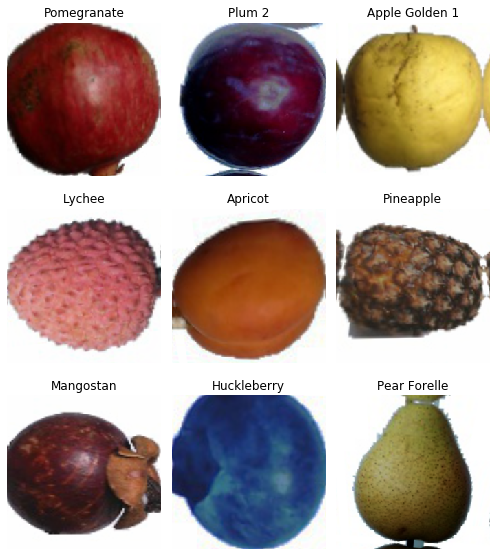

In [5]:
data.show_batch(rows=3, figsize=(7,8))

In [6]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Apple Braeburn',
  'Apple Crimson Snow',
  'Apple Golden 1',
  'Apple Golden 2',
  'Apple Golden 3',
  'Apple Granny Smith',
  'Apple Pink Lady',
  'Apple Red 1',
  'Apple Red 2',
  'Apple Red 3',
  'Apple Red Delicious',
  'Apple Red Yellow 1',
  'Apple Red Yellow 2',
  'Apricot',
  'Avocado',
  'Avocado ripe',
  'Banana',
  'Banana Lady Finger',
  'Banana Red',
  'Beetroot',
  'Blueberry',
  'Cactus fruit',
  'Cantaloupe 1',
  'Cantaloupe 2',
  'Carambula',
  'Cauliflower',
  'Cherry 1',
  'Cherry 2',
  'Cherry Rainier',
  'Cherry Wax Black',
  'Cherry Wax Red',
  'Cherry Wax Yellow',
  'Chestnut',
  'Clementine',
  'Cocos',
  'Dates',
  'Eggplant',
  'Ginger Root',
  'Granadilla',
  'Grape Blue',
  'Grape Pink',
  'Grape White',
  'Grape White 2',
  'Grape White 3',
  'Grape White 4',
  'Grapefruit Pink',
  'Grapefruit White',
  'Guava',
  'Hazelnut',
  'Huckleberry',
  'Kaki',
  'Kiwi',
  'Kohlrabi',
  'Kumquats',
  'Lemon',
  'Lemon Meyer',
  'Limes',
  'Lychee',
  'Mandarine',

## Train model

In [11]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy).to_fp16()

`lr_find` is a nifty fastai function to help generate a plot of loss vs learning rate.

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


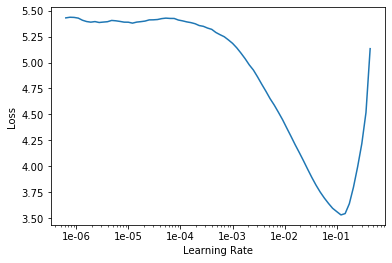

In [13]:
learn.recorder.plot()

After some experimentation, I chose a learning rate of 3e-03, (rule of thumb is to choose a value part way down the loss vs learning rate curve, but not right at the bottom)

In [14]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.073751,0.085959,0.973572,02:54
1,0.033826,0.038667,0.987441,02:56
2,0.008159,0.007650,0.997624,03:00
3,0.001396,0.004158,0.998448,02:54


In [15]:
learn.save('stage-1')

In [16]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (60498 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Chestnut,Chestnut,Chestnut,Chestnut,Chestnut
Path: ../Datasets/fruits/fruits-360;

Valid: LabelList (20622 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Chestnut,Chestnut,Chestnut,Chestnut,Chestnut
Path: ../Datasets/fruits/fruits-360;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64,

The fastai library makes it easy to us 'transfer learning'. I am starting with a resnet50 model trained on ImageNet, and then so far I have just been training the last layer at the end of this pre-trained model. I am making use of all that prior image processing knowledge developed in resnet50 and doing a comparatively much smaller training job here to adapt the model to the cell image data I am working with. This is 'transfer learning'. Next step is to 'unfreeze' all layers and do some gentle training to tweak the rest of the model a little and see if I can improve the results further.

In [17]:
learn.unfreeze()

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


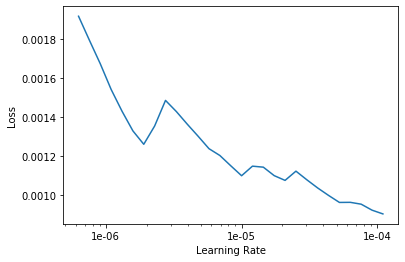

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.001656,0.005618,0.998303,03:38
1,0.001181,0.005116,0.998109,03:38


Fine tuning didn't add anything, the model is already super accurate

In [21]:
learn.save('stage-2')

## Interpretation

In [22]:
learn.load('stage-1');

In [23]:
interp = ClassificationInterpretation.from_learner(learn)

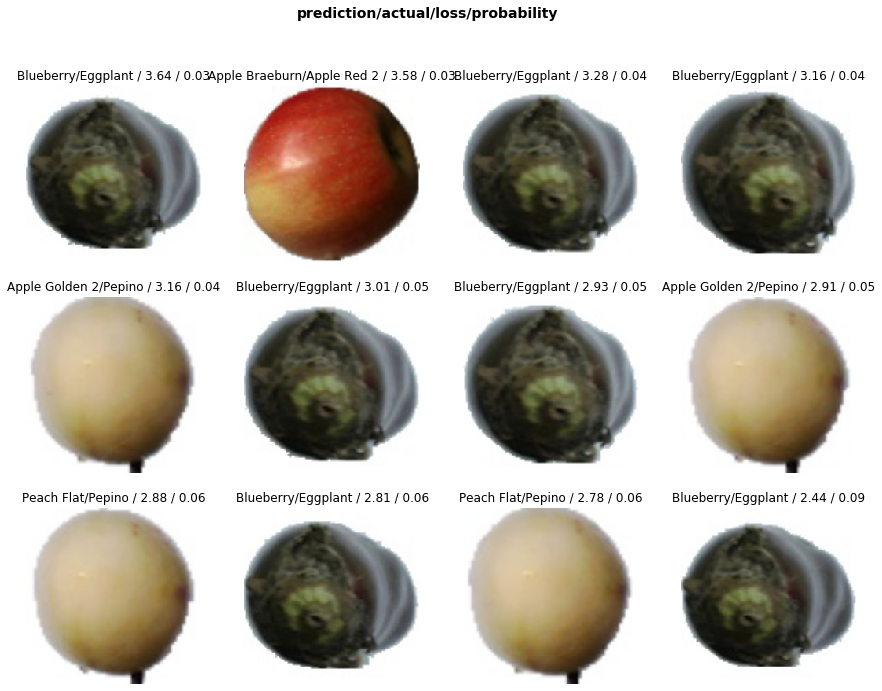

In [24]:
interp.plot_top_losses(12, figsize=(15,11))

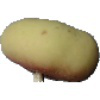

In [35]:
img = open_image(path/'train/Peach Flat/100_100.jpg')
img

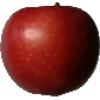

In [36]:
img = open_image(path/'train/Apple Braeburn/100_100.jpg')
img

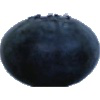

In [37]:
img = open_image(path/'train/Blueberry/100_100.jpg')
img

The accuracy is very high, given that there are 120 different categories of fruit. It does seem reasonable that an image of a peach flat might be confused with a pepino, or red apples and braeburns (another red apple) might get confused. Those squishy eggplant images do look a bit like a blueberry. Still, a human classifier could probably tell them apart, so it might be worth trying to tweak things to see if I can eliminate even these errors.

# After thought
Using resnet 50 and a similar training process to what I used for the cell infection classifier, it is interesting that accuracy is so much higher here, even though the fruit classifier is dealing with 120 categories while the cell infection classifier is merely a binary classifier. This tells me just how important the quality of the dataset is for performance. A clean dataset with well-delineated categories can get high accuracy where a potentially less clean classifier with subtle differences between categories can mean lower accuracy - the low accuracy is in the data, not the model